In [43]:
import os.path
from PIL import Image, ImageEnhance
import numpy as np
import cv2
from matplotlib import pyplot as plt

input_img_dir = 'images/input'
output_img_dir = 'images/output'

file_name = 'image_processing.jpg'
file_path = os.path.join(input_img_dir, file_name)

file_processed_dir = file_name.split('.')[0]
output_processed_path = os.path.join(output_img_dir, file_processed_dir)
os.makedirs(output_processed_path, exist_ok=True)

In [44]:
# Параметры настройки
GAUSSIAN_BLUR_SIZE = (51, 51)
ADAPTIVE_THRESH_BLOCK_SIZE = 11
CONTOUR_AREA_THRESHOLD = 100
RECTANGLE_COLOR = (0, 255, 0)  # BGR
RECTANGLE_THICKNESS = 10

def show_image(subplot, title, image):
    subplot.imshow(image, cmap='gray')
    subplot.title.set_text(title)


def blur_image(img_gray, blur_size=GAUSSIAN_BLUR_SIZE):
    # Применяем адаптивную пороговую функцию
    _, threshold = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Применяем размытие
    img_blur = cv2.GaussianBlur(threshold, blur_size, 0)

    # Для дебага размытия
    _, img_binary = cv2.threshold(img_blur, 150, 255, cv2.THRESH_BINARY_INV)

    return img_blur, img_binary


def find_contour(blur):
    # Ищем контуры
    contours, _ = cv2.findContours(blur, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    areas = sorted([cv2.contourArea(cnt) for cnt in contours], reverse=True)
    areas_mean = np.mean(areas)
    areas_std = np.std(areas)
    print(areas_mean, areas_std)

    # Фильтруем контуры
    # contours = [cnt for cnt in contours if cv2.contourArea(cnt) > areas_std or cv2.contourArea(cnt) < areas_mean]
    print(areas)
    outliers = [x for x in areas if abs(x - areas_std) > areas_std]
    print(outliers)
    contours = [cnt for cnt in contours if abs(cv2.contourArea(cnt) - areas_std) > areas_std]

    # Сортируем контуры по площади
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    return contours

In [45]:
def delete_finger(input_file_path, output_path, blur_size=(20, 5), show=False, debug=False):
    # Загрузка изображения
    image = cv2.imread(input_file_path, cv2.COLOR_BGR2GRAY)

    # Применение размытия для устранения темных участков
    img_blur, img_binary = blur_image(img_gray=image, blur_size=blur_size)

    # Поиск контуров на бинарном изображении
    contours = find_contour(img_blur)

    mask = np.zeros_like(image)  # Создание маски с одним каналом, соответствующим оттенкам серого
    cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)
    inverted_mask = cv2.bitwise_not(mask)

    contoured_image = image.copy()
    output_image = image.copy()

    # Создание маски с контурами
    # contours = find_contour(inverted_mask)
    cv2.drawContours(contoured_image, contours, -1, 255, thickness=10)
    cv2.drawContours(output_image, contours, -1, 255, thickness=cv2.FILLED)

    if show:
        # Отображение результатов
        plt.figure(figsize=(10, 6))
        plt.subplot(241), plt.imshow(image, cmap='gray'), plt.title('Original Image')
        plt.subplot(242), plt.imshow(img_blur, cmap='gray'), plt.title('Binary Image')
        plt.subplot(243), plt.imshow(mask, cmap='gray'), plt.title('Mask')
        plt.subplot(244), plt.imshow(inverted_mask, cmap='gray'), plt.title('Inverted Mask')
        plt.subplot(245), plt.imshow(contoured_image, cmap='gray'), plt.title('Contoured Image')
        plt.subplot(246), plt.imshow(output_image, cmap='gray'), plt.title('Output Image')
        plt.show()

        plt.savefig(os.path.join(output_path, f'00_f_fig_{file_name}'))

    if debug:
        cv2.imwrite(os.path.join(output_path, f'01_f_binary_image_{file_name}'), img_blur)
        cv2.imwrite(os.path.join(output_path, f'02_f_mask_{file_name}'), mask)
        cv2.imwrite(os.path.join(output_path, f'03_f_inverted_mask_{file_name}'), inverted_mask)
        cv2.imwrite(os.path.join(output_path, f'04_f_contoured_image_{file_name}'), contoured_image)
        cv2.imwrite(os.path.join(output_path, f'05_f_output_image_{file_name}'), output_image)

    ext = input_file_path.split(".")[-1]
    out = input_file_path.replace(ext, f'out.{ext}')
    cv2.imwrite(out, output_image)
    return out

In [46]:
def process_image(input_file_path, output_dir, processing_steps, show=False, debug=False):
    """
    - contrast factor of 0.0 gives a solid grey image. A factor of 1.0 gives the original image.
    - brightness factor of 1.0 gives the original image.
    - sharpness factor of 0.0 gives a blurred image, a factor of 1.0 gives the original image,
    and a factor of 2.0 gives a sharpened image.
    """
    print(os.path.split(input_file_path))
    if not processing_steps:
        processing_steps = [
            ("Contrast", 1.0),
            ("Brightness", 1.0),
            ("Sharpness", 1.0)
        ]

    image = Image.open(input_file_path)
    image = image.convert("L")  # Convert to grayscale

    processed_images = []

    for step_name, step_factor in processing_steps:
        enhancer = getattr(ImageEnhance, step_name)(image)
        processed_image = enhancer.enhance(step_factor)
        processed_images.append((processed_image.copy(), step_name, step_factor))
        image = processed_image

    if debug:
        for index, (processed_image, step_name, step_factor) in enumerate(processed_images, start=1):
            processed_image.save(os.path.join(output_dir, f'{index:02d}_p_{step_name.lower()}_{step_factor}_{file_name}'))

    if show:
        num_steps = len(processed_images)
        num_columns = num_steps + 1
        plt.figure(figsize=(4 * num_columns, 6))

        plt.subplot(1, num_columns, 1), plt.imshow(image, cmap='gray'), plt.title('Original Image')

        for index, (processed_image, step_name, step_factor) in enumerate(processed_images, start=2):
            plt.subplot(1, num_columns, index), plt.imshow(processed_image, cmap='gray'), plt.title(f'{step_name}: {step_factor}')

        plt.tight_layout()
        plt.show()

    steps_2_name_prefix = '__'.join([f'{p[0]}{c}' for p, c in processing_steps])
    output_file_path = os.path.join(output_dir, f'{len(processed_images) + 1:02d}_p_final_{steps_2_name_prefix}_{file_name}')
    image.save(output_file_path)
    return output_file_path

In [47]:
process_steps = [
    ("Brightness", 1.4),
    ("Contrast", 1.7),
    ("Sharpness", 1.4),
]

('images/input', 'delete_finger.jpg')


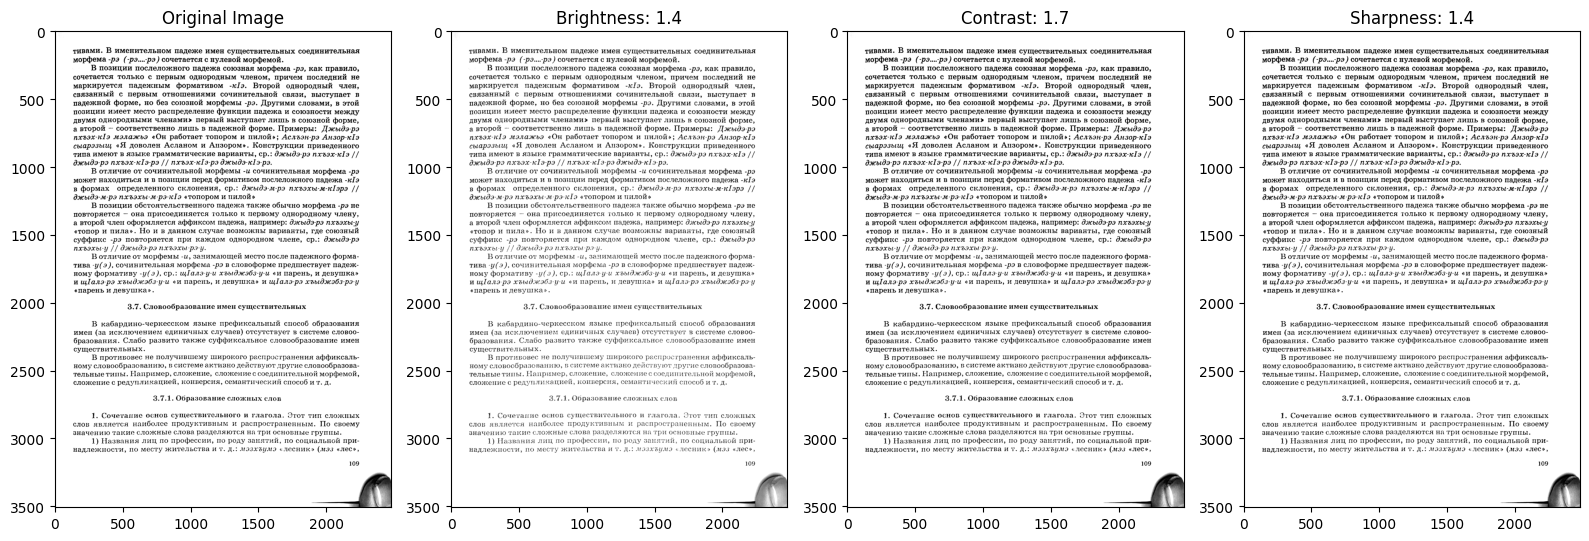

369.89146248085757 731.6814357247503
[36260.5, 1187.5, 1184.0, 1156.0, 1148.5, 1128.5, 1127.0, 1126.0, 1120.5, 1109.0, 1102.5, 1101.5, 1100.5, 1100.5, 1095.5, 1091.0, 1085.0, 1082.5, 1082.0, 1078.5, 1077.0, 1071.0, 1070.5, 1068.0, 1058.0, 1049.5, 1046.0, 1028.0, 1025.5, 1023.5, 1019.5, 1019.0, 1019.0, 1016.5, 1013.5, 1011.0, 1010.5, 1010.0, 1007.0, 996.0, 990.5, 989.0, 953.5, 948.0, 927.5, 920.5, 900.0, 895.5, 881.0, 845.5, 827.5, 827.0, 816.5, 801.0, 800.5, 788.5, 785.5, 785.0, 771.0, 770.5, 766.0, 755.5, 752.0, 747.5, 743.0, 741.5, 741.0, 733.0, 732.0, 730.5, 728.5, 727.0, 724.0, 718.5, 718.5, 712.5, 711.5, 711.0, 709.5, 709.0, 708.0, 707.5, 705.5, 705.0, 704.5, 704.0, 703.0, 701.0, 701.0, 700.0, 700.0, 698.5, 696.0, 696.0, 695.5, 695.5, 694.5, 693.5, 691.0, 690.5, 688.0, 687.5, 687.5, 687.0, 686.5, 686.0, 685.5, 682.5, 682.0, 679.0, 678.5, 678.5, 678.0, 675.5, 675.5, 675.5, 674.5, 674.0, 674.0, 672.0, 672.0, 672.0, 671.0, 670.5, 670.5, 670.5, 670.5, 670.0, 669.5, 668.5, 668.5, 667.5

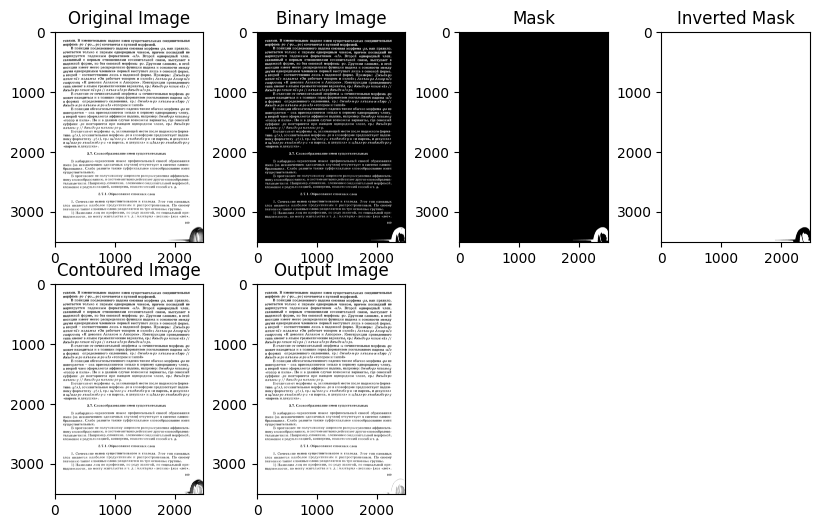

'images/output/delete_finger/04_p_final_B1.4__C1.7__S1.4_delete_finger.out.jpg'

<Figure size 640x480 with 0 Axes>

In [48]:
processed_img = process_image(
    file_path, output_processed_path,
    processing_steps=process_steps,
    show=True
)
delete_finger(
    processed_img, output_processed_path,
    blur_size=(1, 1),
    show=True,
    debug=True
)

In [39]:
import itertools
process_steps_permutations = list(itertools.permutations(process_steps))

apply_filter_output_path = os.path.join(output_processed_path, 'apply_filter')
os.makedirs(apply_filter_output_path, exist_ok=True)

for process_steps_p in process_steps_permutations:
    output_path = process_image(file_path, apply_filter_output_path, processing_steps=process_steps_p)

('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')


In [42]:
apply_filter_product_output_path = os.path.join(output_processed_path, 'apply_filter_product')
os.makedirs(apply_filter_product_output_path, exist_ok=True)

def frange(start, stop, step):
    i = start
    while i <= stop:
        yield i
        i += step

step_size = 0.5  # Step size for adjusting the factors
min_factor = 1.2
max_factor = 1.8

factor_range = [round(factor, 1) for factor in frange(min_factor, max_factor, step_size)]
combinations = list(itertools.product(factor_range, repeat=len(process_steps)))
process_steps_permutations = list(itertools.permutations(process_steps))

for process_steps_p in process_steps_permutations:
    for combination in combinations:
        custom_steps = [(step_name, factor) for (step_name, _), factor in zip(process_steps_p, combination)]

        output_path = process_image(file_path, apply_filter_product_output_path, processing_steps=custom_steps)

('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input', 'image_processing.jpg')
('images/input',